In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from recurrent_attention import RecurrentAttention

## Overhead stuff

Helper functions for batching, resetting hidden states, etc.

In [2]:
# Data gen parameters
num_batches = 500
num_eval_batches = 20
ntokens = 7
dep_len = 6

# Training hyperparameters
eval_batch_size = 20
batch_size = 50
seq_len = 11
dropout = 0.1
clip = 1
lr = 0.05
warmup_steps = 5
decay_factor = 0.5  # Higher => faster learning rate decay
smoothing = 0.001

epochs = 50
log_interval = 100   # Print log every `log_interval` batches

In [3]:
# Model hyperparameters
embed_size = 64
encode_size = 32
h_size = 16
decode_size = 32
decode_out_size = 64
n_enc_layers = 1
attn_rnn_layers = 1
n_dec_layers = 1
smooth_align = True

bidirectional_attn = False

## Generate data

In [4]:
# Generate some token transition probabilities
probs = np.random.randint(1, 10*ntokens, size = tuple(ntokens for _ in range(dep_len+1)))
# Normalize
probs = probs / (probs.sum(axis = -1)[..., np.newaxis])
probs.shape

(7, 7, 7, 7, 7, 7, 7)

In [5]:
def gen_data(num_batches, batch_size, seq_len):
    num_data = num_batches * batch_size * seq_len
    # Initialize numpy array for the generated data
    data = np.zeros((num_data,), dtype = int)
    # Randomly generate a series of starting tokens
    ts = [np.random.randint(ntokens, size = 1) for _ in range(dep_len)]
    # Generate the data
    for i in range(num_data):
        pr = probs[ts].squeeze()
        data[i] = np.random.choice(ntokens, p = pr)
        ts.pop(0)
        ts.append(data[i].reshape(1,1))
    return torch.from_numpy(data).type(torch.LongTensor)

### Helper functions

In [6]:
# Starting from sequential data, `batchify` arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.
def batchify(data, batch_size):
    # Work out how cleanly we can divide the dataset into batches
    nbatches = data.size(0) // batch_size
    # Trim off any extra elements that wouldn't cleanly fit
    data = data.narrow(0, 0, nbatches * batch_size)
    # Evenly divide the data across the batches
    data = data.view(batch_size, -1).t().contiguous()
    return data  # [seq_len, batch_size]

# Wraps hidden states into new Variables to detach them from their history
def repackage_hidden(h):
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)
    
# `get_batch` subdivides the source data into chunks of the specified length.
# E.g., using the example for the `batchify` function above and a length of 2,
# we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the `batchify` function. The chunks are along dimension 0, corresponding
# to the `seq_len` dimension in the LSTM.
def get_batch(source, i, seq_len, evaluate = False):
    seq_len = min(seq_len, len(source) - 1 - i)
    data = Variable(source[i : i+seq_len], volatile = evaluate)
    target = Variable(source[i+1 : i+1+seq_len].view(-1), volatile = evaluate)
    return data, target

In [7]:
train_data = batchify(gen_data(num_batches, batch_size, seq_len), batch_size)
val_data = batchify(gen_data(num_eval_batches, batch_size, seq_len), eval_batch_size)
test_data = batchify(gen_data(num_eval_batches, batch_size, seq_len), eval_batch_size)
train_data.size(), val_data.size(), test_data.size()

(torch.Size([5500, 50]), torch.Size([550, 20]), torch.Size([550, 20]))

Label smoothing class for regularization.

In [8]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx = None, smoothing = 0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss()
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = torch.zeros_like(x.data)
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist.add_(self.smoothing / self.size)
        if self.padding_idx is not None:
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad = False)) * ntokens

Learning rate scheduler that sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

In [9]:
def get_lr_scheduler(h_size, warmup, optimizer):
    lrate = lambda e: h_size**(-0.5) * min((e+1)**(-decay_factor), (e+1) * warmup**(-(decay_factor+1)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lrate)

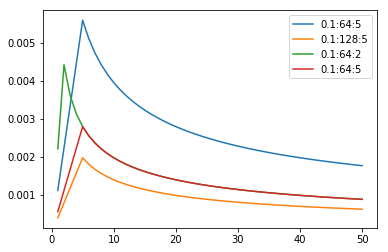

In [10]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps//2),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend([
    "%.1f:%d:%d" % (2*lr, embed_size, warmup_steps),
    "%.1f:%d:%d" % (lr, embed_size*2, warmup_steps),
    "%.1f:%d:%d" % (lr, embed_size, warmup_steps//2),
    "%.1f:%d:%d" % (lr, embed_size, warmup_steps),
])

## Model class

In [11]:
class RNNModel(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, embed_size, encode_size, h_size,
                 decode_size, decode_out_size, n_enc_layers, attn_rnn_layers,
                 n_dec_layers, align_location = False, loc_align_size = 1,
                 loc_align_kernel = 1, smooth_align = False, bidirectional_attn = False,
                 tie_wts = True, dropout = 0.1):
        super(RNNModel, self).__init__()
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.embed_size = embed_size
        self.encode_size = encode_size
        self.h_size = h_size
        self.decode_size = decode_size
        self.decode_out_size = decode_out_size
        self.n_enc_layers = n_enc_layers
        self.attn_rnn_layers = attn_rnn_layers
        self.n_dec_layers = n_dec_layers
        self.align_location = align_location
        self.loc_align_size = loc_align_size
        self.loc_align_kernel = loc_align_kernel
        self.smooth_align = smooth_align
        self.bidirectional_attn = bidirectional_attn
        self.tie_wts = tie_wts
        self.dropout = dropout
        
        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        self.embedding = nn.Embedding(src_vocab, embed_size)
        self.encoders = nn.ModuleList([
            nn.LSTM(
                input_size = embed_size if i == 0 else encode_size,
                hidden_size = encode_size, dropout = dropout
            ) for i in range(n_enc_layers)
        ])
        self.attn = RecurrentAttention(
            in_size = encode_size, h_size = h_size, out_size = decode_size,
            align_location = align_location, loc_align_size = loc_align_size,
            loc_align_kernel = loc_align_kernel, smooth_align = smooth_align,
            num_rnn_layers = attn_rnn_layers, attn_act_fn = 'ReLU',
            dropout = dropout, bidirectional = bidirectional_attn
        )
        self.decoders = nn.ModuleList([
            nn.LSTM(
                input_size = decode_size, dropout = dropout,
                hidden_size = decode_size if i < n_dec_layers-1 else decode_out_size,
            ) for i in range(n_dec_layers)
        ])
        self.projection = nn.Linear(decode_out_size, tgt_vocab)
        if tie_wts and src_vocab == tgt_vocab and embed_size == decode_out_size:
            self.embedding.weight = self.projection.weight
        self.log_softmax = nn.LogSoftmax(dim = -1)
            
        # For visualizations
        self.save_wts = False
        self.enc_out = None
        self.dec_out = None
        
    def init(self):
        for subnet in [self.encoders, self.decoders]:
            for layer in subnet:
                for p in layer.parameters():
                    if p.dim() > 1:
                        nn.init.xavier_normal(p)
                    else:
                        p.data.fill_(0)
        for p in self.projection.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)
            else:
                p.data.fill_(0)
        self.attn.init()
        
    def init_states(self, batch_size):
        encoder_states = [
            (
                Variable(torch.zeros(1, batch_size, self.encode_size)),
                Variable(torch.zeros(1, batch_size, self.encode_size))
            ) for _ in range(self.n_enc_layers)
        ]
        attn_states = self.attn.init_rnn_states(batch_size)
        decoder_states = [
            (
                Variable(torch.zeros(
                    1, batch_size, self.decode_size if i < self.n_dec_layers-1 else self.decode_out_size
                )),
                Variable(torch.zeros(
                    1, batch_size, self.decode_size if i < self.n_dec_layers-1 else self.decode_out_size
                ))
            ) for i in range(self.n_dec_layers)
        ]
        return encoder_states, attn_states, decoder_states
    
    def forward(self, inputs, states):
        enc_states, attn_states, dec_states = states
        if self.save_wts:
            self.enc_out = []
            self.dec_out = []
        
        embeddings = self.embedding(inputs) * np.sqrt(self.embed_size)
        
        new_enc_states = []
        enc_in = self.drop(self.relu(embeddings))
        for states, encoder in zip(enc_states, self.encoders):
            enc_out, new_enc_state = encoder(enc_in, states)
            new_enc_states.append(new_enc_state)
            if self.save_wts:
                self.enc_out.append(enc_out.data.clone())
            enc_in = enc_out
                
        attn_out, new_attn_states = self.attn(enc_out, attn_states)
        
        new_dec_states = []
        dec_in = attn_out
        for states, decoder in zip(dec_states, self.decoders):
            dec_out, new_dec_state = decoder(dec_in, states)
            new_dec_states.append(new_dec_state)
            if self.save_wts:
                self.dec_out.append(dec_out.data.clone())
            dec_in = dec_out
        
        logits = self.projection(dec_out)
        output = self.log_softmax(logits)
        
        return output, (new_enc_states, new_attn_states, new_dec_states)
    
    def train(self, mode = True, save_wts = False):
        super(RNNModel, self).train(mode)
        self.attn.save_attn_wts = save_wts
        self.save_wts = save_wts
        
    def eval(self, save_wts = True):
        super(RNNModel, self).eval()
        self.attn.save_attn_wts = save_wts
        self.save_wts = save_wts

## Initialize model, criterion, optimizer, and learning rate scheduler

In [12]:
model = RNNModel(
    src_vocab = ntokens, tgt_vocab = ntokens, embed_size = embed_size,
    encode_size = encode_size, h_size = h_size, decode_size = decode_size,
    decode_out_size = decode_out_size, n_enc_layers = n_enc_layers,
    attn_rnn_layers = attn_rnn_layers, n_dec_layers = n_dec_layers,
    dropout = dropout, smooth_align = smooth_align
)
model.init()
criterion = LabelSmoothing(ntokens, smoothing = smoothing)
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, optimizer)
# Reference
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 45976


## Train

Define training and validation loops

In [13]:
def train():
    # Use random length sequences
    seq_lens = []
    tot_len = 0
    jitter = 0.15 * seq_len
    num_data = train_data.size(0)
    while tot_len < num_data - 2:
        if num_data - tot_len - 2 <= seq_len + jitter:
            slen = num_data - tot_len - 2
        else:
            slen = int(np.random.normal(seq_len, jitter))
            if slen <= 0:
                slen = seq_len    # eh
            if tot_len + slen >= num_data - jitter - 2:
                slen = num_data - tot_len - 2
        seq_lens.append(slen)
        tot_len += slen
    # Turn on training mode
    model.train(save_wts = False)
    # Initialize RNN states
    states = model.init_states(batch_size)
    # Prep metainfo
    total_loss = 0
    total_epoch_loss = 0
    start_time = time.time()
    for batch, i in enumerate(np.cumsum(seq_lens)):
        # Get training data
        data, targets = get_batch(train_data, i, seq_lens[batch])
        # Repackage the hidden states
        states = model.init_states(batch_size)  #repackage_hidden(states)
        # Zero out gradients
        model.zero_grad()
        
        # Run the model forward
        output, _states = model(data, states)
        if np.isnan(output.data).any():
            return 0, total_epoch_loss[0], data, targets, states, _states
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        if np.isnan(loss.data[0]):
            return 1, total_epoch_loss[0], data, targets, states, _states
        states = _states
        # Propagate loss gradient backwards
        loss.backward()
        # Clip gradients
        if batch % log_interval == 0 and batch > 0:
            # Save gradient statistics before they're changed cuz we'll be logging this batch
            parameters = [p for p in model.parameters() if p.grad is not None]
            # Calculate the largest (absolute) gradient of all elements in the model parameters
            max_grad = max([p.grad.data.abs().max() for p in parameters])
        total_norm = nn.utils.clip_grad_norm(model.parameters(), clip)
        # Scale the batch learning rate so that shorter sequences aren't "stronger"
        scaled_lr = lr_scheduler.get_lr()[0] * np.sqrt(seq_lens[batch] / seq_len)
        for param_group in optimizer.param_groups:
            param_group['lr'] = scaled_lr
        # Update parameters
        optimizer.step()
        
        # Get some metainfo
        total_loss += loss.data
        total_epoch_loss += loss.data * data.size(0)
        if batch % log_interval == 0 and batch > 0:
            elapsed = time.time() - start_time
            cur_loss = total_loss[0] / log_interval
            print(' b {:3d}/{:3d} >> {:6.1f} ms/b | lr: {:8.2g} | grad norm: {:4.2f} | max abs grad: {:7.3f} | loss: {:4.2f} | perp.: {:6.2f}'.format(
                batch, len(seq_lens), elapsed * 1000/log_interval, scaled_lr, total_norm, max_grad, cur_loss, np.exp(cur_loss)
            ))
            total_loss = 0
            start_time = time.time()
    return -1, total_epoch_loss[0] / num_data, None, None, None, None

In [14]:
def evaluate(data_src, save_wts = True):
    model.eval(save_wts = save_wts)
    total_loss = 0
    states = model.init_states(eval_batch_size)
    for i in range(0, data_src.size(0) - 1, seq_len):
        # Get data
        data, targets = get_batch(data_src, i, seq_len, evaluate = True)
        # Repackage the hidden states
        states = model.init_states(eval_batch_size)  #repackage_hidden(states)
        # Evaluate
        output, states = model(data, states)
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        total_loss += loss.data * data.size(0)
    return total_loss[0] / data_src.size(0)

Train and evaluate

In [15]:
WIDTH = 112
CAUSES = ['output', 'grad']
for epoch in range(epochs):
    lr_scheduler.step()
    print('Epoch {:3d}/{:3d}) lr = {:0.4g}{}'.format(epoch+1, epochs, np.mean(lr_scheduler.get_lr()[0]), ' (warmup)' if epoch < warmup_steps else ''))
    start_time = time.time()
    stat, train_loss, data, targets, states, nstates = train()
    if stat in list(range(len(CAUSES))):
        c = CAUSES[stat]
        n = (WIDTH - len(c) - 4) // 2
        print('\n' + (' '*n) + 'NaN ' + c)
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(val_data, save_wts = False)
    max_param = max([p.data.abs().max() for p in model.parameters() if p.grad is not None])
    print('-' * WIDTH)
    print('Elapsed time: {:6.2f} sec | train_loss: {:5.2f} | train_perp: {:6.2f} | valid_loss: {:5.2f} | valid_perp.: {:6.2f}'.format(
        elapsed, train_loss, np.exp(train_loss), val_loss, np.exp(val_loss)
    ))
    print('=' * WIDTH)
    print('\n')

Epoch   1/ 50) lr = 0.000559 (warmup)
 b 100/522 >>   36.2 ms/b | lr:  0.00053 | grad norm: 0.25 | max abs grad:   0.030 | loss: 1.91 | perp.:   6.73
 b 200/522 >>   30.3 ms/b | lr:  0.00051 | grad norm: 0.39 | max abs grad:   0.038 | loss: 1.79 | perp.:   5.96
 b 300/522 >>   32.3 ms/b | lr:  0.00056 | grad norm: 0.48 | max abs grad:   0.037 | loss: 1.73 | perp.:   5.65
 b 400/522 >>   31.8 ms/b | lr:  0.00053 | grad norm: 0.44 | max abs grad:   0.050 | loss: 1.71 | perp.:   5.51
 b 500/522 >>   31.9 ms/b | lr:  0.00051 | grad norm: 0.56 | max abs grad:   0.062 | loss: 1.69 | perp.:   5.40
----------------------------------------------------------------------------------------------------------------
Elapsed time:  16.86 sec | train_loss:  1.76 | train_perp:   5.79 | valid_loss:  1.66 | valid_perp.:   5.25


Epoch   2/ 50) lr = 0.001118 (warmup)
 b 100/528 >>   30.4 ms/b | lr:    0.001 | grad norm: 0.47 | max abs grad:   0.033 | loss: 1.68 | perp.:   5.35
 b 200/528 >>   29.8 ms/b | l

 b 100/522 >>   30.6 ms/b | lr:   0.0022 | grad norm: 3.22 | max abs grad:   0.283 | loss: 0.72 | perp.:   2.06
 b 200/522 >>   28.8 ms/b | lr:   0.0018 | grad norm: 2.96 | max abs grad:   0.239 | loss: 0.67 | perp.:   1.95
 b 300/522 >>   28.9 ms/b | lr:   0.0018 | grad norm: 2.00 | max abs grad:   0.212 | loss: 0.69 | perp.:   2.00
 b 400/522 >>   29.0 ms/b | lr:   0.0018 | grad norm: 2.24 | max abs grad:   0.350 | loss: 0.65 | perp.:   1.91
 b 500/522 >>   30.5 ms/b | lr:   0.0018 | grad norm: 1.65 | max abs grad:   0.176 | loss: 0.69 | perp.:   2.00
----------------------------------------------------------------------------------------------------------------
Elapsed time:  15.36 sec | train_loss:  0.70 | train_perp:   2.02 | valid_loss:  0.81 | valid_perp.:   2.25


Epoch  11/ 50) lr = 0.001884
 b 100/527 >>   29.9 ms/b | lr:   0.0019 | grad norm: 2.55 | max abs grad:   0.216 | loss: 0.65 | perp.:   1.92
 b 200/527 >>   28.5 ms/b | lr:    0.002 | grad norm: 2.91 | max abs grad:  

 b 100/526 >>   30.8 ms/b | lr:   0.0016 | grad norm: 4.24 | max abs grad:   0.483 | loss: 0.52 | perp.:   1.68
 b 200/526 >>   29.4 ms/b | lr:   0.0015 | grad norm: 4.21 | max abs grad:   0.355 | loss: 0.51 | perp.:   1.66
 b 300/526 >>   31.2 ms/b | lr:   0.0014 | grad norm: 3.17 | max abs grad:   0.240 | loss: 0.50 | perp.:   1.65
 b 400/526 >>   28.9 ms/b | lr:   0.0013 | grad norm: 1.41 | max abs grad:   0.140 | loss: 0.48 | perp.:   1.61
 b 500/526 >>   30.0 ms/b | lr:   0.0014 | grad norm: 2.71 | max abs grad:   0.274 | loss: 0.49 | perp.:   1.63
----------------------------------------------------------------------------------------------------------------
Elapsed time:  15.75 sec | train_loss:  0.52 | train_perp:   1.68 | valid_loss:  0.41 | valid_perp.:   1.50


Epoch  20/ 50) lr = 0.001398
 b 100/527 >>   28.7 ms/b | lr:   0.0013 | grad norm: 1.85 | max abs grad:   0.215 | loss: 0.49 | perp.:   1.63
 b 200/527 >>   29.6 ms/b | lr:    0.001 | grad norm: 1.95 | max abs grad:  

 b 100/518 >>   34.3 ms/b | lr:   0.0011 | grad norm: 1.37 | max abs grad:   0.204 | loss: 0.44 | perp.:   1.56
 b 200/518 >>   36.6 ms/b | lr:   0.0012 | grad norm: 1.48 | max abs grad:   0.114 | loss: 0.43 | perp.:   1.54
 b 300/518 >>   36.1 ms/b | lr:   0.0012 | grad norm: 3.87 | max abs grad:   0.413 | loss: 0.40 | perp.:   1.50
 b 400/518 >>   35.2 ms/b | lr:   0.0013 | grad norm: 3.28 | max abs grad:   0.387 | loss: 0.43 | perp.:   1.54
 b 500/518 >>   35.7 ms/b | lr:   0.0011 | grad norm: 0.98 | max abs grad:   0.130 | loss: 0.40 | perp.:   1.49
----------------------------------------------------------------------------------------------------------------
Elapsed time:  18.23 sec | train_loss:  0.44 | train_perp:   1.55 | valid_loss:  0.39 | valid_perp.:   1.47


Epoch  29/ 50) lr = 0.001161
 b 100/526 >>   36.3 ms/b | lr:   0.0012 | grad norm: 2.27 | max abs grad:   0.204 | loss: 0.41 | perp.:   1.51
 b 200/526 >>   32.4 ms/b | lr:   0.0012 | grad norm: 2.45 | max abs grad:  

 b 100/528 >>   36.2 ms/b | lr:   0.0011 | grad norm: 4.23 | max abs grad:   0.368 | loss: 0.36 | perp.:   1.43
 b 200/528 >>   33.4 ms/b | lr:  0.00093 | grad norm: 1.64 | max abs grad:   0.145 | loss: 0.36 | perp.:   1.43
 b 300/528 >>   34.2 ms/b | lr:    0.001 | grad norm: 1.78 | max abs grad:   0.200 | loss: 0.36 | perp.:   1.44
 b 400/528 >>   31.7 ms/b | lr:    0.001 | grad norm: 2.46 | max abs grad:   0.219 | loss: 0.37 | perp.:   1.45
 b 500/528 >>   32.2 ms/b | lr:   0.0011 | grad norm: 3.72 | max abs grad:   0.430 | loss: 0.37 | perp.:   1.44
----------------------------------------------------------------------------------------------------------------
Elapsed time:  17.64 sec | train_loss:  0.38 | train_perp:   1.46 | valid_loss:  0.27 | valid_perp.:   1.30


Epoch  38/ 50) lr = 0.001014
 b 100/526 >>   29.9 ms/b | lr:  0.00092 | grad norm: 1.08 | max abs grad:   0.159 | loss: 0.33 | perp.:   1.40
 b 200/526 >>   34.5 ms/b | lr:  0.00097 | grad norm: 1.37 | max abs grad:  

 b 100/527 >>   32.6 ms/b | lr:    0.001 | grad norm: 3.13 | max abs grad:   0.574 | loss: 0.34 | perp.:   1.40
 b 200/527 >>   27.2 ms/b | lr:    0.001 | grad norm: 2.85 | max abs grad:   0.263 | loss: 0.34 | perp.:   1.40
 b 300/527 >>   26.4 ms/b | lr:  0.00092 | grad norm: 2.20 | max abs grad:   0.261 | loss: 0.32 | perp.:   1.38
 b 400/527 >>   25.8 ms/b | lr:  0.00088 | grad norm: 1.99 | max abs grad:   0.228 | loss: 0.34 | perp.:   1.41
 b 500/527 >>   26.2 ms/b | lr:  0.00083 | grad norm: 0.67 | max abs grad:   0.090 | loss: 0.33 | perp.:   1.40
----------------------------------------------------------------------------------------------------------------
Elapsed time:  14.59 sec | train_loss:  0.35 | train_perp:   1.41 | valid_loss:  0.23 | valid_perp.:   1.25


Epoch  47/ 50) lr = 0.0009117
 b 100/534 >>   27.2 ms/b | lr:  0.00087 | grad norm: 0.79 | max abs grad:   0.079 | loss: 0.34 | perp.:   1.40
 b 200/534 >>   29.1 ms/b | lr:  0.00087 | grad norm: 1.34 | max abs grad: 

In [16]:
if stat in list(range(len(CAUSES))):
    params = [p for p in model.parameters() if p.grad is not None]
    print(any([np.isnan(p.data).any() for p in params]), any([np.isnan(p.grad.data).any() for p in params]))
    
    enc_states, attn_states, dec_states = states
    relu = nn.ReLU()
    log_softmax = nn.LogSoftmax(dim = -1)
    
    embeddings = model.embedding(data)
    enc_out, new_enc_states = model.encoder(model.drop(embeddings))
    attn_out, new_attn_states = model.attn(enc_out, attn_states)
    dec_out, new_dec_states = model.decoder(relu(attn_out))
    output = model.projection(dec_out)
    
    print([
        np.isnan(p.data).any() for p in [embeddings, enc_out, attn_out, dec_out, output]
    ])

In [17]:
test_loss = evaluate(test_data, save_wts = True)
print('test_loss: {:5.2f} | test_perplexity: {:5.2f}'.format(
    test_loss, np.exp(test_loss)
))

test_loss:  0.25 | test_perplexity:  1.28


## Evaluate predictions

In [18]:
nb = 4
model.eval(save_wts = True)
# Get some data from a random point in the test_data set
states = model.init_states(nb)
data, targets = get_batch(test_data, 120, seq_len, evaluate = True)
data = data[:,:nb].contiguous()
targets = targets.view(seq_len, -1)[:,:nb].contiguous()

In [19]:
# Run the model forward
output, states = model(data, states)
# Convert the output log probabilities to normal probabilities
output = output.exp()
# Get the argmax of each step in the output
output_p, output_idx = output.max(dim = -1)

Compare the predicted output word indices to the targets

In [20]:
targets = targets.t()
output_idx = output_idx.t()
for i in range(nb):
    # Print the output with the targets
    seqs = torch.cat([targets[i].unsqueeze(0), output_idx[i].unsqueeze(0)], 0)
    # Number incorrectly predicted
    num_incorrect = (targets[i] != output_idx[i]).sum()
    print('%d incorrectly predicted\n' % num_incorrect[0], seqs)

1 incorrectly predicted
 Variable containing:
    1     5     2     0     5     1     3     6     2     6     0
    1     5     2     0     5     1     3     6     2     6     5
[torch.LongTensor of size 2x11]

2 incorrectly predicted
 Variable containing:
    5     4     1     2     6     1     6     2     1     5     2
    5     4     1     2     6     1     2     2     1     5     1
[torch.LongTensor of size 2x11]

1 incorrectly predicted
 Variable containing:
    6     2     5     1     2     6     4     1     3     1     5
    6     2     5     1     2     6     4     1     3     1     1
[torch.LongTensor of size 2x11]

0 incorrectly predicted
 Variable containing:
    2     2     4     3     4     6     3     6     2     6     5
    2     2     4     3     4     6     3     6     2     6     5
[torch.LongTensor of size 2x11]



## Visualizations
List of modules in the model for reference:

In [21]:
modules = list(model.modules())
list(enumerate(modules))

[(0, RNNModel(
    (drop): Dropout(p=0.1)
    (relu): ReLU()
    (embedding): Embedding(7, 64)
    (encoders): ModuleList(
      (0): LSTM(64, 32, dropout=0.1)
    )
    (attn): RecurrentAttention(
      (drop): Dropout(p=0.1)
      (softmax): Softmax()
      (sigmoid): Sigmoid()
      (rnn_stack): ModuleList(
        (0): LSTMCell(64, 16)
      )
      (alignment): Linear(in_features=48, out_features=1)
      (attention): Linear(in_features=80, out_features=32)
      (attn_act_fn): ReLU()
    )
    (decoders): ModuleList(
      (0): LSTM(32, 64, dropout=0.1)
    )
    (projection): Linear(in_features=64, out_features=7)
    (log_softmax): LogSoftmax()
  )), (1, Dropout(p=0.1)), (2, ReLU()), (3, Embedding(7, 64)), (4, ModuleList(
    (0): LSTM(64, 32, dropout=0.1)
  )), (5, LSTM(64, 32, dropout=0.1)), (6, RecurrentAttention(
    (drop): Dropout(p=0.1)
    (softmax): Softmax()
    (sigmoid): Sigmoid()
    (rnn_stack): ModuleList(
      (0): LSTMCell(64, 16)
    )
    (alignment): Linear

Some basic weight heat maps to start:

(7, 64)

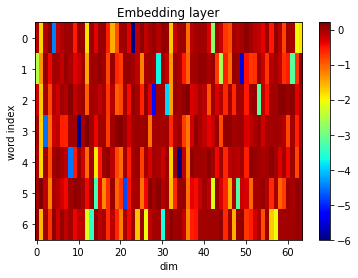

In [23]:
embed_wts = np.array(modules[3].weight.data)
plt.imshow(embed_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('dim'); plt.ylabel('word index');
plt.title('Embedding layer')
plt.colorbar()
embed_wts.shape

In [24]:
attn = modules[6]

(32, 80)

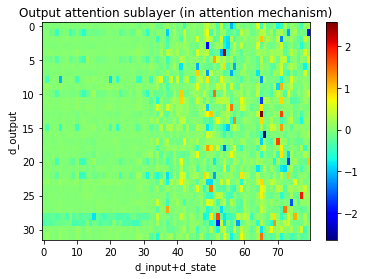

In [25]:
attn_wts = np.array(attn.attention.weight.data)
plt.imshow(attn_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('d_input+d_state'); plt.ylabel('d_output')
plt.title('Output attention sublayer (in attention mechanism)')
plt.colorbar()
attn_wts.shape

Sequence attention visualization by mapping the alignment weights (in the attention mechanism) at each step of the input:

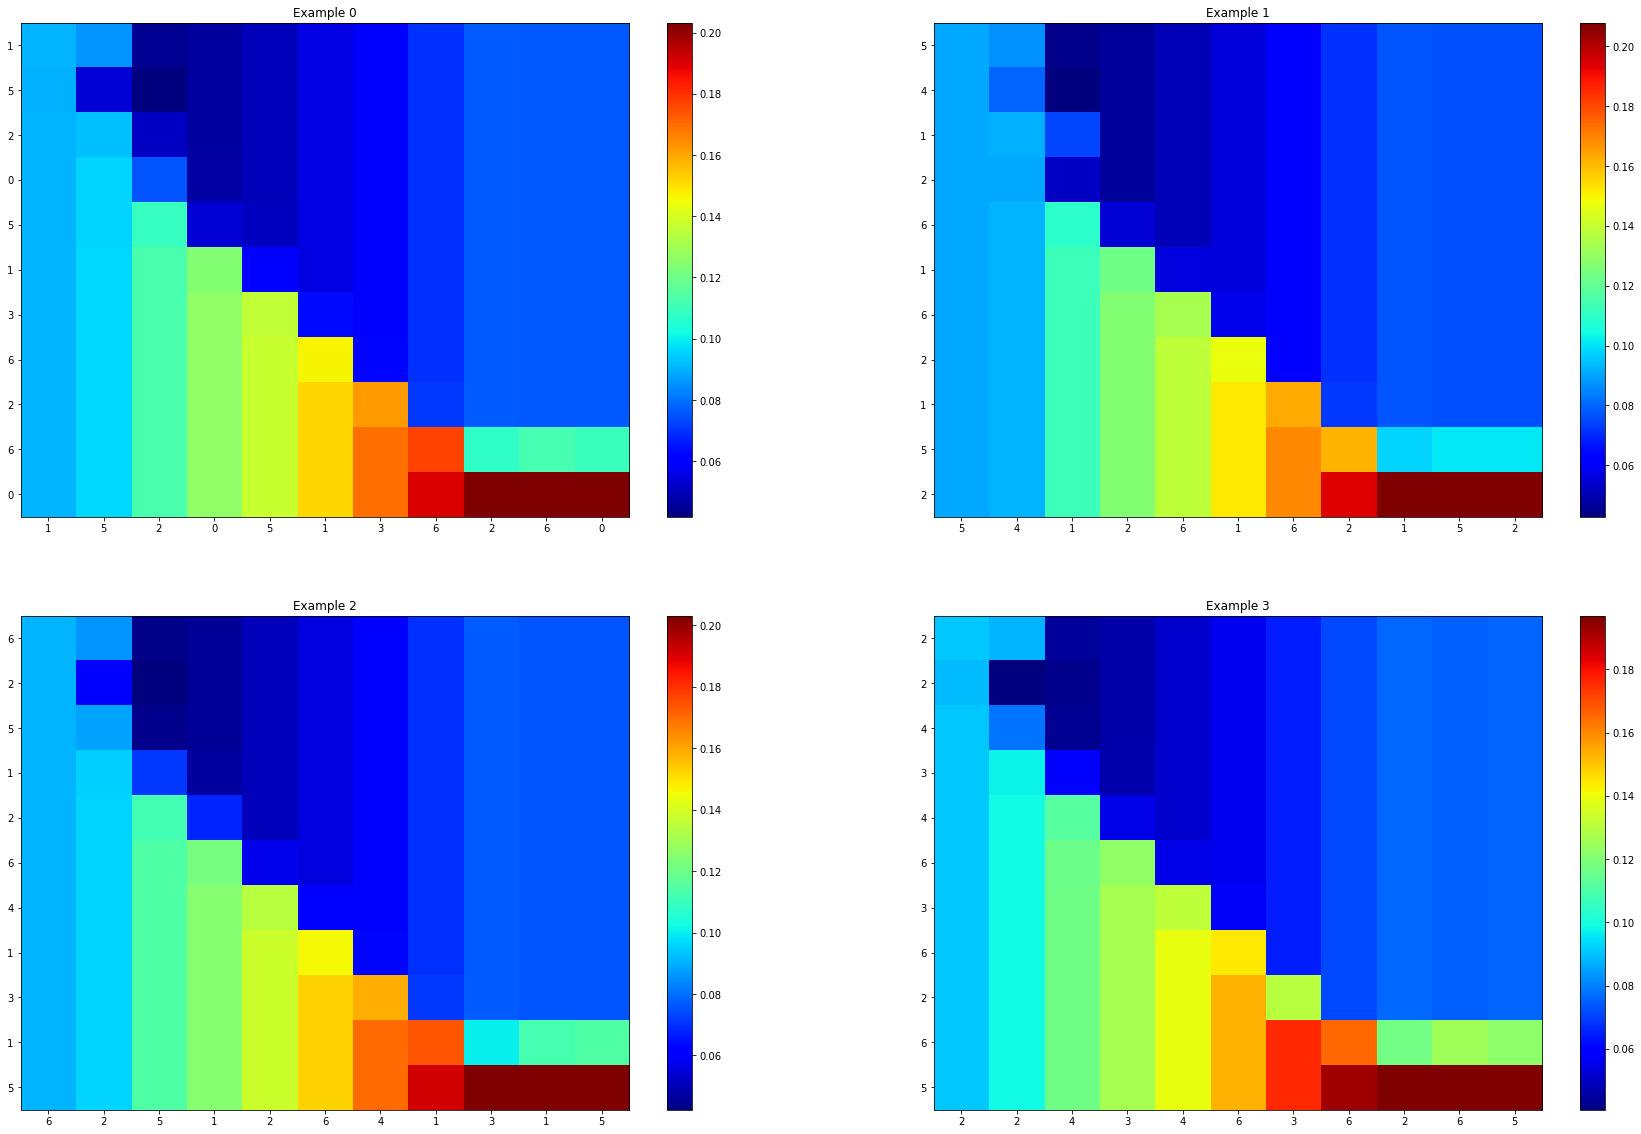

In [26]:
cols = 2
rows = nb//cols
fig, axs = plt.subplots(rows, cols, figsize = (30, 20))
for b in range(nb):
    wts = attn.attn_wts[:,b,:]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    r = b // cols
    c = b % cols
    ax = axs[r, c]
    im = ax.imshow(wts, aspect = 'auto', cmap = 'jet')
    # Fix labels
    s = list(targets[b].data)
    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(s)
    ax.set_yticks(range(seq_len))
    ax.set_yticklabels(s)
    ax.set_title('Example %d' % b)
    fig.colorbar(im, ax = ax)
plt.show()